In [4]:
import glob
import os
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
matplotlib.style.use('ggplot')

import seaborn as sns
# sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

plt.rcParams["figure.figsize"] = (20,4)


In [5]:
filename = "./formatted/google_5m.csv"
df = pd.read_csv(filename, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8351 entries, 0 to 8350
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time_stamp         8351 non-null   int64  
 1   meanCPUUsage       8351 non-null   float64
 2   CanonicalMemUsage  8351 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 195.9 KB


In [6]:
df = df.set_index('time_stamp')
df.index = pd.to_datetime(df.index)
df.describe()


,meanCPUUsage,CanonicalMemUsage
count,8351.000000,8351.000000
mean,1.194050,0.257648
std,2.251440,0.333216
min,0.052199,0.079895
25%,0.611832,0.166684
50%,0.810781,0.185741
75%,1.094810,0.218376
max,56.863121,5.581155


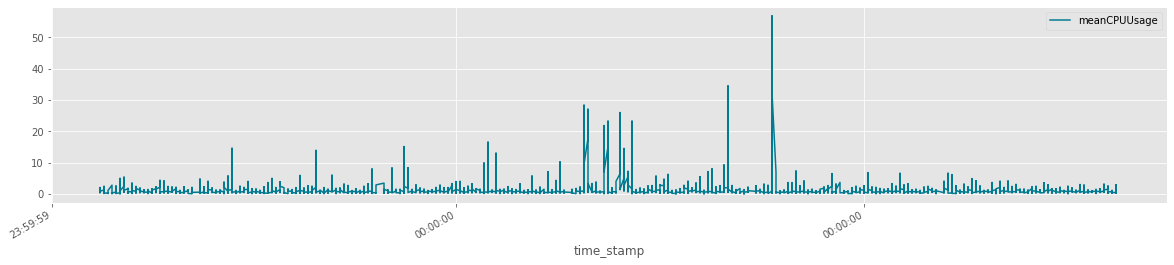

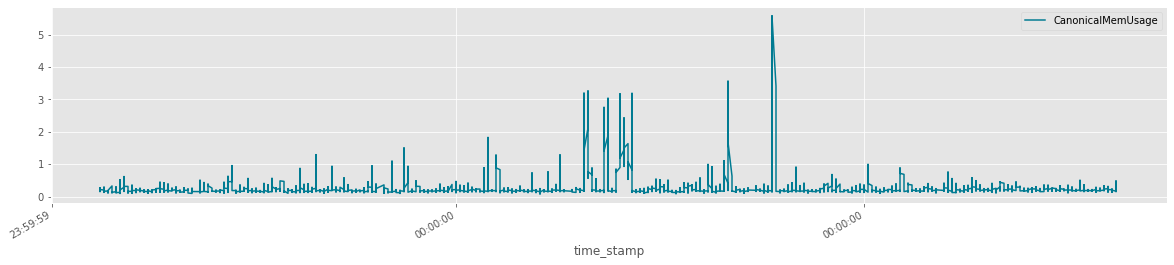

In [7]:
df.plot(y='meanCPUUsage', use_index=True)
df.plot(y='CanonicalMemUsage', use_index=True)

In [8]:
# Transformation
df.interpolate(method='time', inplace=True)

### Test stationarity by Augmented Dickey-Fuller (ADF) unit root test
Augmented Dickey-Fuller (ADF) unit root test is defined as follows:

    + $H_0$: the data possesses a unit root (random walk) and it is non-stationary.

Result intepretation:

    + if ADF statistic test < 1% 5% 10% (Critical Values) then $H_0$ is rejected
    + if P-Value < 0.05 then $H_0$ is rejected

**A stationary series** is one where the values of the series is not a function of time t.j. the statistical properties of the series like mean, variance and autocorrelation are constant over time.

**Autocorrelation** of the series is the correlation of the series with its previous values

In [9]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if (missing==0):
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col)
            # print("\t1. ADF : ",dftest[0])
            print("\t2. P-Value : ", dftest[1])
            print("\t3. Num Of Lags : ", dftest[2])
            # print("\t4. Num of observations used for ADF regression and Critical Values calculation :", dftest[3])
            # print("\t5. Critical Values :")
            # for key, val in dftest[4].items():
            #    print("\t\t",key, ": ", val)   
        else:
            print("shit")
            print(dftest[0], dftest[1], dftest[2])
        print(col)
        # plot_acf(df[col])
        # plt.show()

tmp = []
cols_selected = [x for x in cols_selected if x not in tmp]
print(len(cols_selected))
cols_selected

meanCPUUsage
	2. P-Value :  9.394643433662052e-22
	3. Num Of Lags :  36
meanCPUUsage
CanonicalMemUsage
	2. P-Value :  1.820207569704678e-18
	3. Num Of Lags :  36
CanonicalMemUsage
2


['meanCPUUsage', 'CanonicalMemUsage']

### Seasonal-Trend decomposition using LOESS (STL)
    + LOESS (locally estimated scatterplot smoothing)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2351 entries, 1970-01-01 00:00:00.001800600 to 1970-01-01 00:00:00.002505900
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   meanCPUUsage       2351 non-null   float64
 1   CanonicalMemUsage  2351 non-null   float64
dtypes: float64(2)
memory usage: 55.1 KB
None


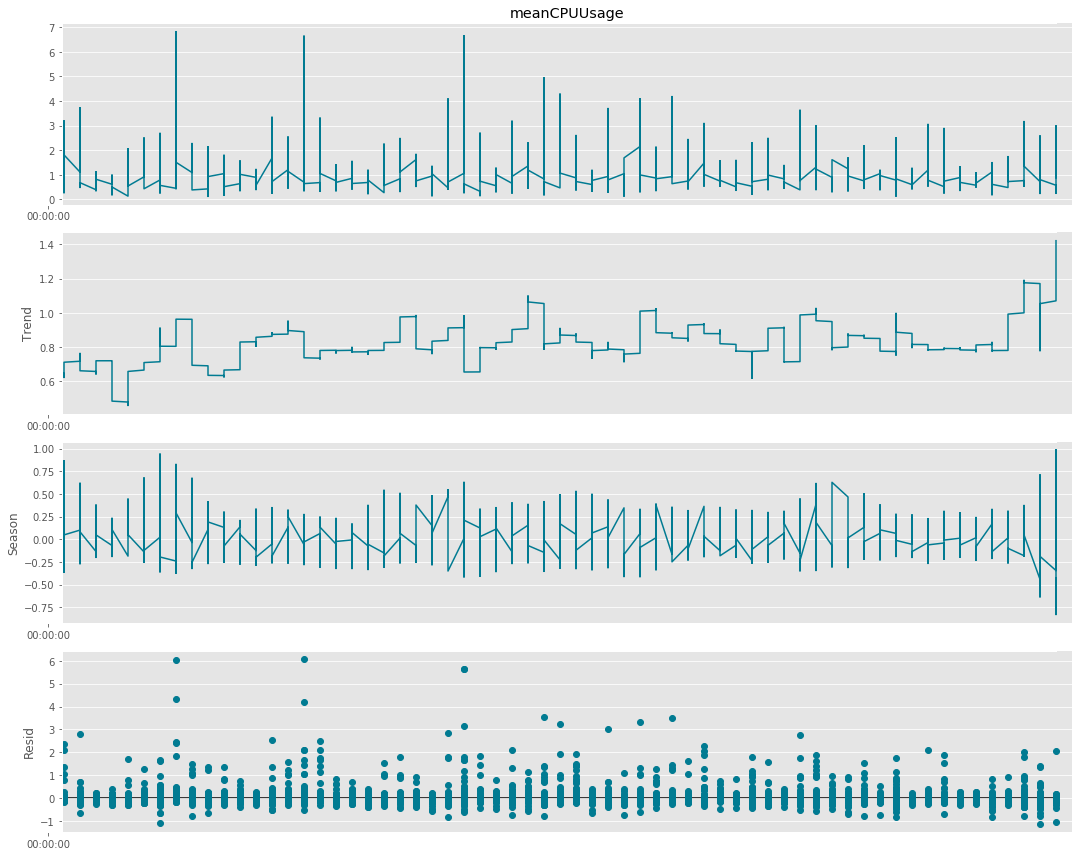

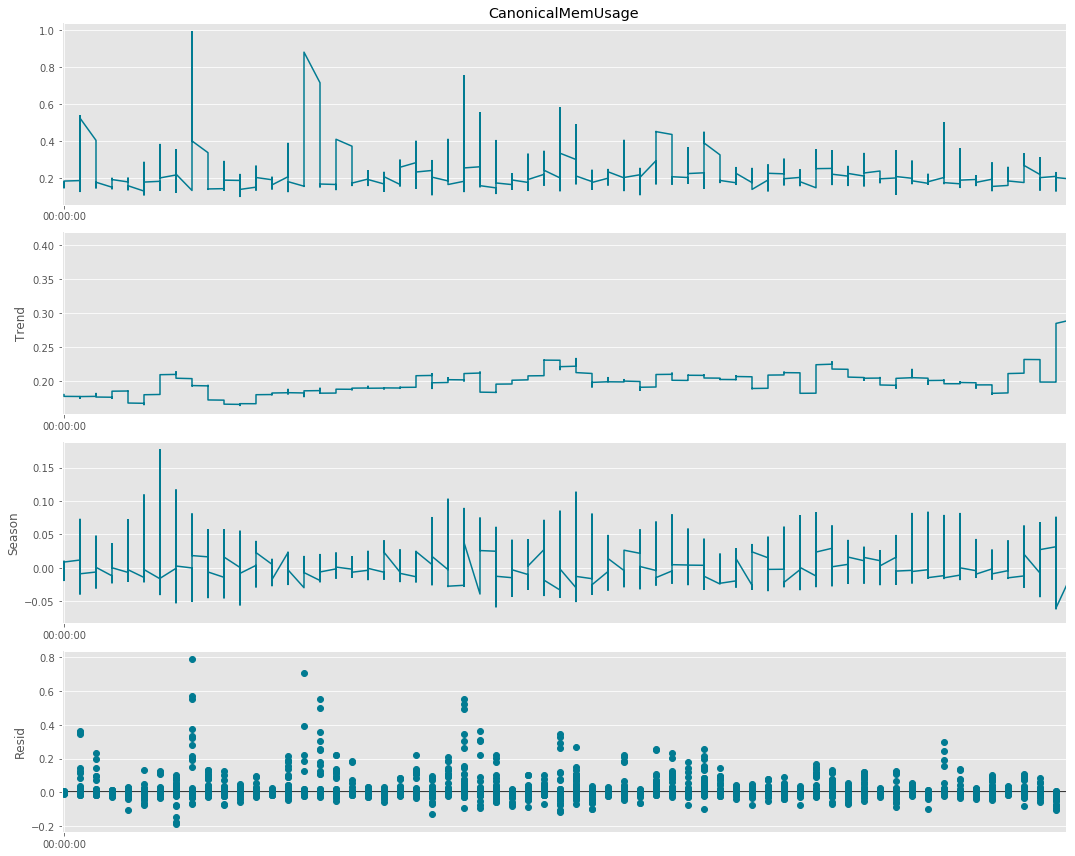

In [10]:
df = df[cols_selected]
df = df[6000:]
print(df.info())

test_stl = True
if test_stl:
    cols=cols_selected
    df_result = pd.DataFrame()
    for col in cols:
        column = df[col]
        #result = STL(column, period=6, robust=True).fit()    
        #df_result[col] = result.trend

        result = STL(column, period=36, robust=True).fit()    
        df_result[col] = result.trend + result.seasonal

        plt.rcParams["figure.figsize"] = (15, 12)
        result.plot()
        plt.show()

## Train and test data

In [11]:
percent = 0.01
# df_result.clip(lower=df_result.quantile(0), upper=df_result.quantile(1-percent), axis=1, inplace=True)   

n = len(df.index)
m = 500
df_train = df_result.head(n-m)
df_test  = df_result.tail(m)

df_train.to_csv('formatted/gg_5m_train.tsv', sep='\t', index = False, header=True)
df_test.to_csv('formatted/gg_5m_test.tsv', sep='\t', index = False, header=True)

print(df_train.shape, df_test.shape)
print(df_train.head())
print(df_test.head())

(1851, 2) (500, 2)
                               meanCPUUsage  CanonicalMemUsage
time_stamp                                                    
1970-01-01 00:00:00.001800600      0.663551           0.169728
1970-01-01 00:00:00.001800900      0.653167           0.170488
1970-01-01 00:00:00.001801200      0.697319           0.175683
1970-01-01 00:00:00.001801500      0.809705           0.180196
1970-01-01 00:00:00.001801800      0.749648           0.177794
                               meanCPUUsage  CanonicalMemUsage
time_stamp                                                    
1970-01-01 00:00:00.002356200      0.787064           0.209054
1970-01-01 00:00:00.002356500      0.779965           0.205299
1970-01-01 00:00:00.002356800      0.726077           0.207817
1970-01-01 00:00:00.002357100      0.868400           0.219309
1970-01-01 00:00:00.002357400      1.028194           0.215712


In [13]:
print(df[6000:])

Empty DataFrame
Columns: [meanCPUUsage, CanonicalMemUsage]
Index: []


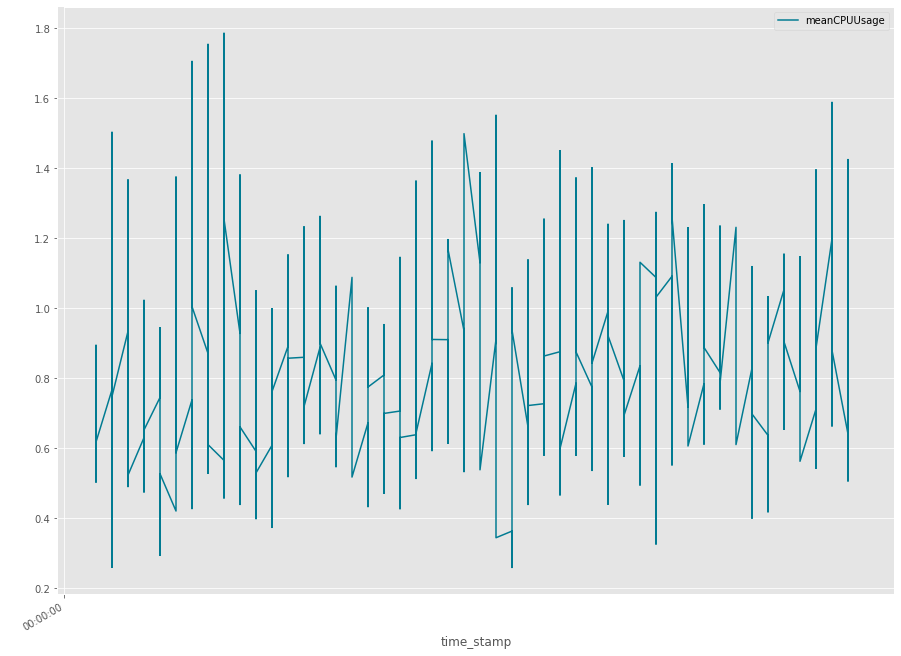

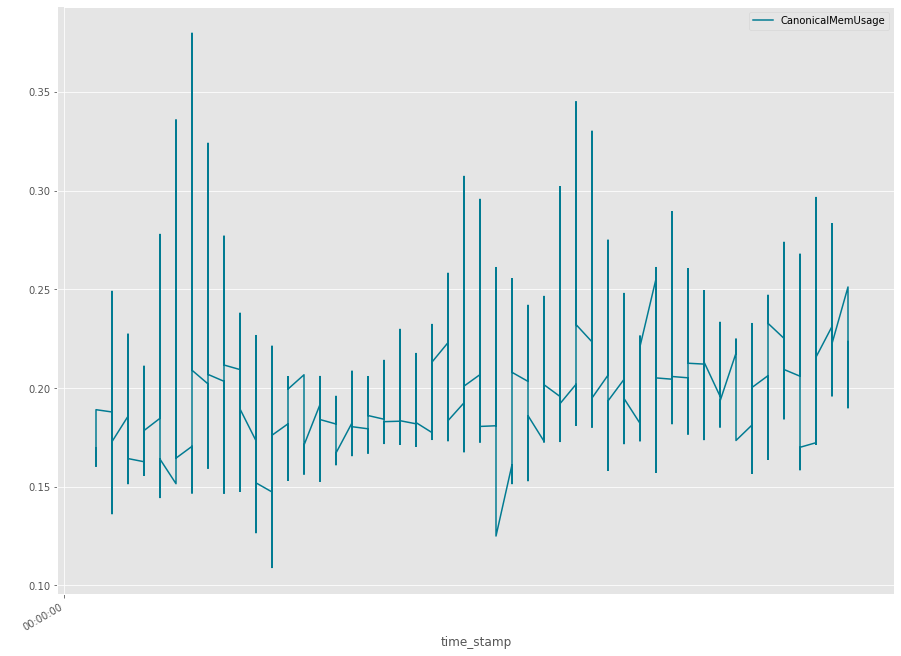

In [14]:
df_train.plot(y='meanCPUUsage', use_index=True)
df_train.plot(y='CanonicalMemUsage', use_index=True)

In [18]:
# Test with Internet UK and Internet EU dataset
filename = "./formatted/it_eu_5m.csv"
df = pd.read_csv(filename, sep=',', usecols=[4])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14772 entries, 0 to 14771
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   traffic (in Megabyte)  14772 non-null  float64
dtypes: float64(1)
memory usage: 115.5 KB


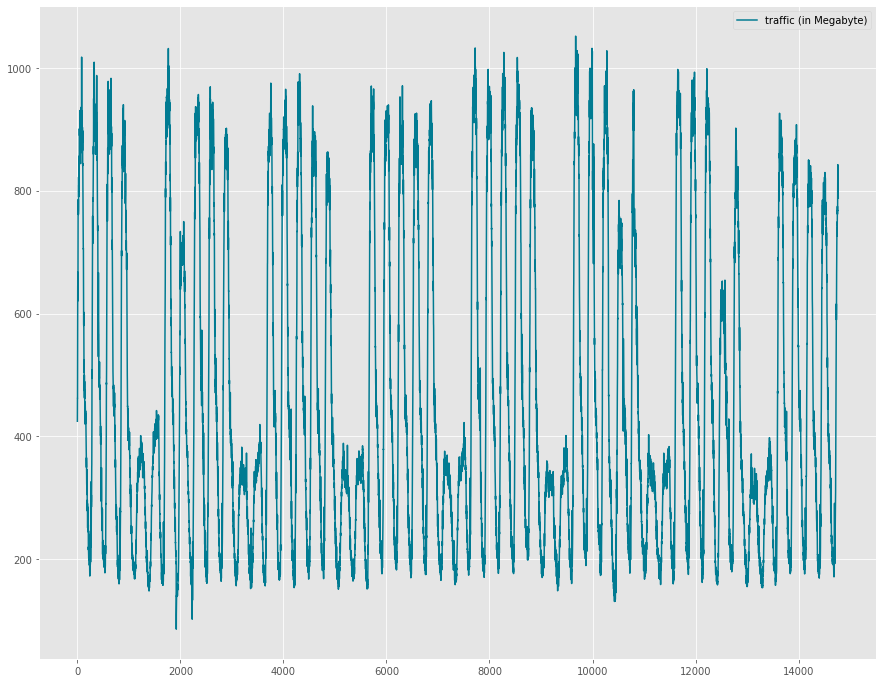

In [19]:
df.plot(y='traffic (in Megabyte)', use_index=True)

In [20]:
# Transformation
df.interpolate(method='time', inplace=True)

In [21]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if (missing==0):
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col)
            # print("\t1. ADF : ",dftest[0])
            print("\t2. P-Value : ", dftest[1])
            print("\t3. Num Of Lags : ", dftest[2])
            # print("\t4. Num of observations used for ADF regression and Critical Values calculation :", dftest[3])
            # print("\t5. Critical Values :")
            # for key, val in dftest[4].items():
            #    print("\t\t",key, ": ", val)   
        else:
            print("shit")
            print(dftest[0], dftest[1], dftest[2])
        print(col)
        # plot_acf(df[col])
        # plt.show()

tmp = []
cols_selected = [x for x in cols_selected if x not in tmp]
print(len(cols_selected))


traffic (in Megabyte)
	2. P-Value :  3.418229435893893e-24
	3. Num Of Lags :  41
traffic (in Megabyte)
1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14772 entries, 0 to 14771
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   traffic (in Megabyte)  14772 non-null  float64
dtypes: float64(1)
memory usage: 115.5 KB
None


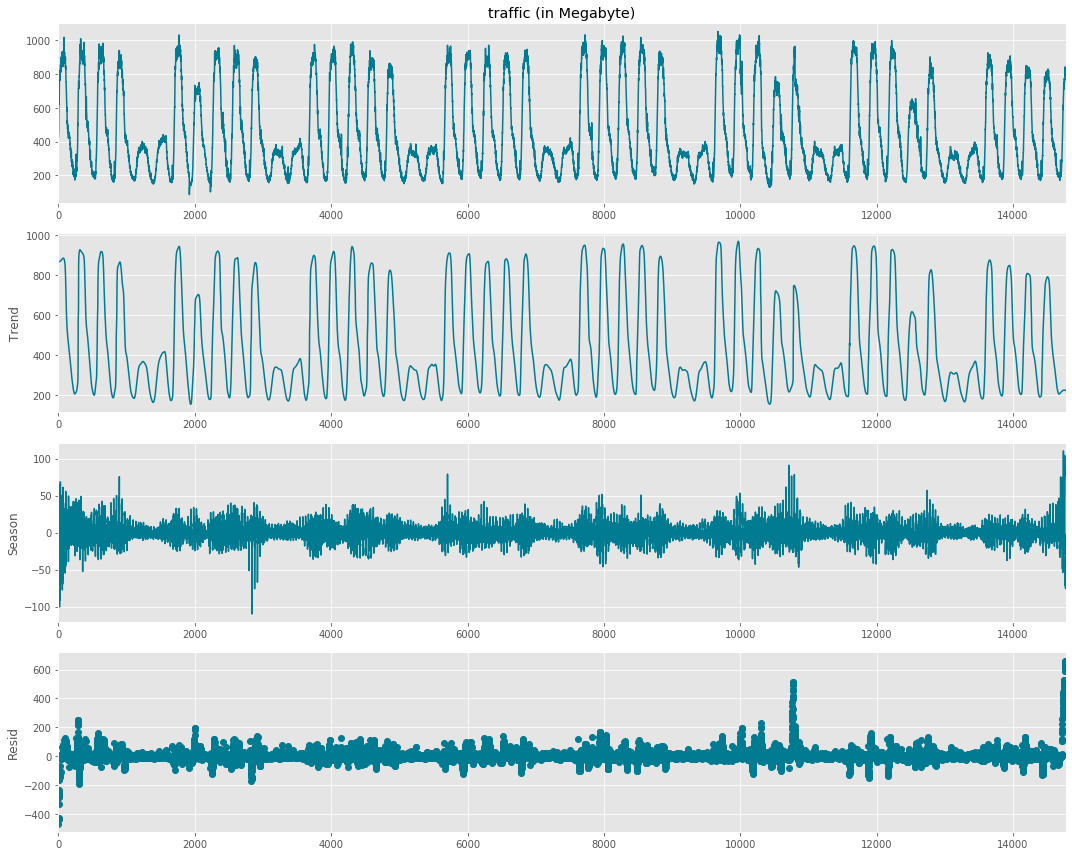

In [22]:
df = df[cols_selected]
print(df.info())

test_stl = True
if test_stl:
    cols=cols_selected
    df_result = pd.DataFrame()
    for col in cols:
        column = df[col]
        #result = STL(column, period=6, robust=True).fit()    
        #df_result[col] = result.trend

        result = STL(column, period=41, robust=True).fit()    
        df_result[col] = result.trend + result.seasonal

        plt.rcParams["figure.figsize"] = (15, 12)
        result.plot()
        plt.show()

In [23]:
df_result.to_csv('formatted/it_eu_fm_5m.csv', index = False, header=True)

## Test with UK Internet Traffic dataset

In [25]:
filename = "./formatted/it_uk_5m.csv"
df = pd.read_csv(filename, sep=',', usecols=[2])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19888 entries, 0 to 19887
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bytes   19888 non-null  float64
dtypes: float64(1)
memory usage: 155.5 KB


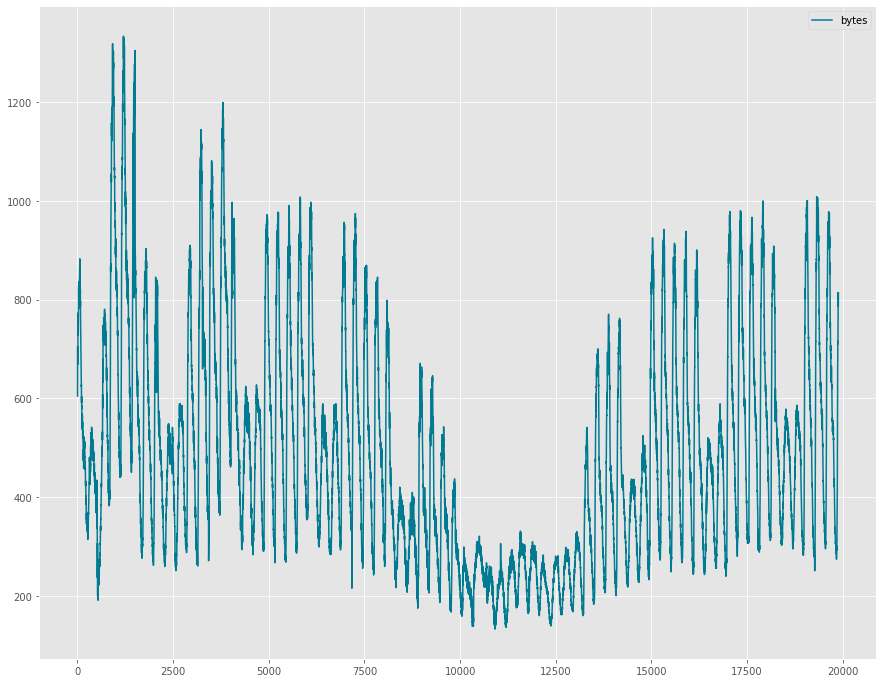

In [26]:
df.plot(y='bytes', use_index=True)

In [27]:
# Transformation
df.interpolate(method='time', inplace=True)

In [28]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if (missing==0):
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col)
            # print("\t1. ADF : ",dftest[0])
            print("\t2. P-Value : ", dftest[1])
            print("\t3. Num Of Lags : ", dftest[2])
            # print("\t4. Num of observations used for ADF regression and Critical Values calculation :", dftest[3])
            # print("\t5. Critical Values :")
            # for key, val in dftest[4].items():
            #    print("\t\t",key, ": ", val)   
        else:
            print("shit")
            print(dftest[0], dftest[1], dftest[2])
        print(col)
        # plot_acf(df[col])
        # plt.show()

tmp = []
cols_selected = [x for x in cols_selected if x not in tmp]
print(len(cols_selected))


bytes
	2. P-Value :  9.011312933866729e-21
	3. Num Of Lags :  43
bytes
1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19888 entries, 0 to 19887
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bytes   19888 non-null  float64
dtypes: float64(1)
memory usage: 155.5 KB
None


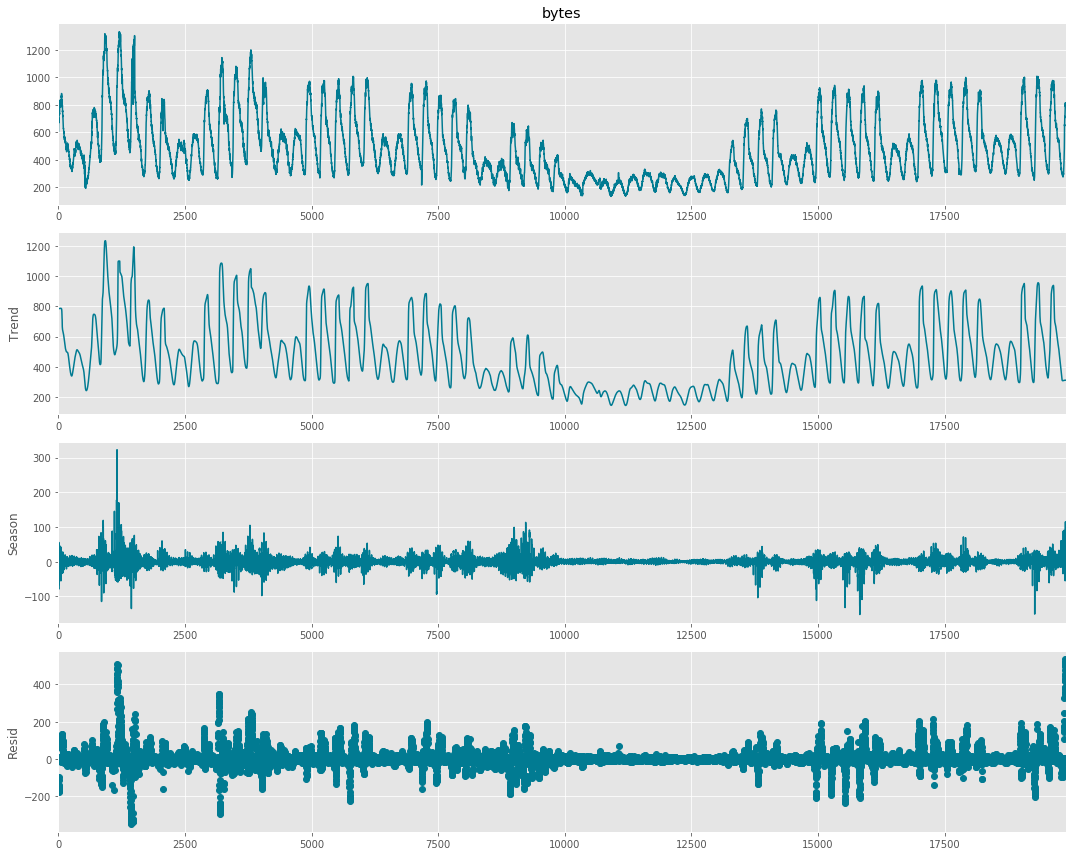

In [32]:
df = df[cols_selected]
print(df.info())

test_stl = True
if test_stl:
    cols=cols_selected
    df_result = pd.DataFrame()
    df_noise = pd.DataFrame()
    for col in cols:
        column = df[col]
        #result = STL(column, period=6, robust=True).fit()    
        #df_result[col] = result.trend

        result = STL(column, period=43, robust=True).fit()    
        df_result[col] = result.trend + result.seasonal
        df_noise[col] = result.resid

        plt.rcParams["figure.figsize"] = (15, 12)
        result.plot()
        plt.show()

In [33]:
df_result.to_csv('formatted/it_uk_fm_5m.csv', index = False, header=True)

In [34]:
df_noise.to_csv('formatted/it_uk_fm_5m_noise.csv', index = False, header=True)

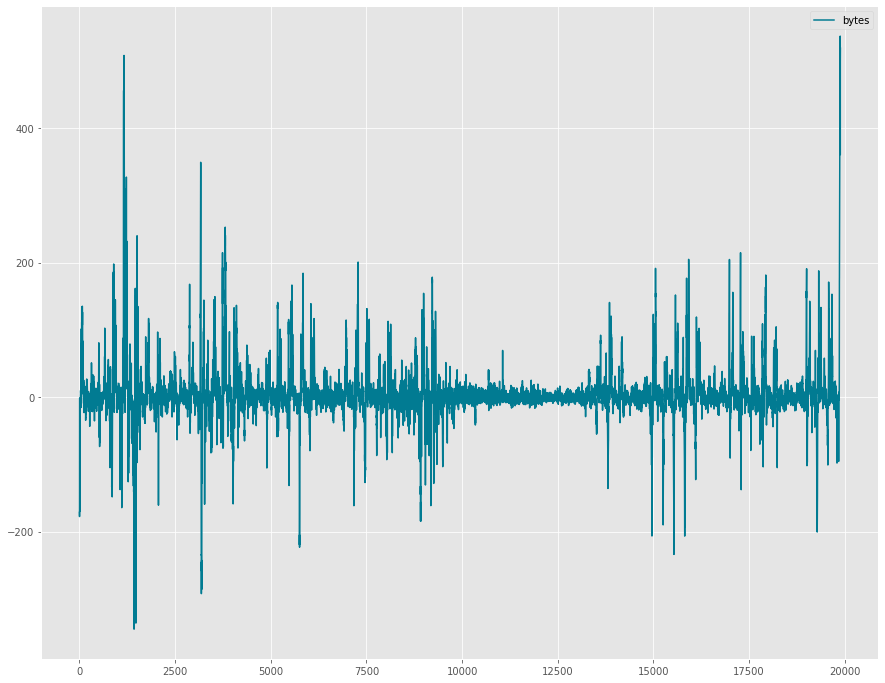

In [35]:
df_noise.plot()

# STL the noise, lets see.

In [37]:
filename = "./formatted/it_uk_fm_5m_noise.csv"
df = pd.read_csv(filename, sep=',', usecols=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19888 entries, 0 to 19887
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bytes   19888 non-null  float64
dtypes: float64(1)
memory usage: 155.5 KB


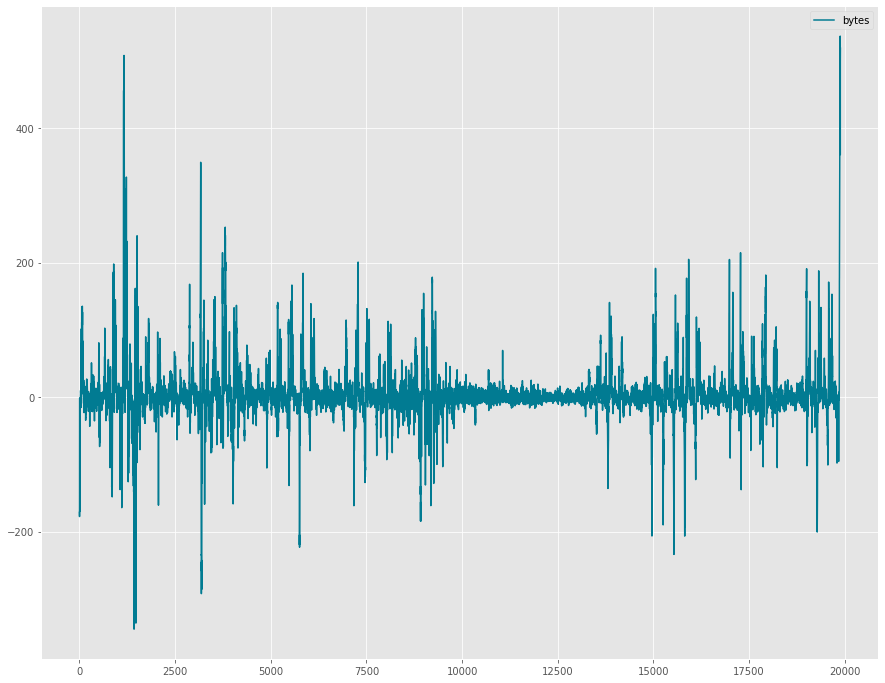

In [38]:
df.plot(y='bytes', use_index=True)

In [39]:
# Transformation
df.interpolate(method='time', inplace=True)

In [40]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if (missing==0):
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col)
            # print("\t1. ADF : ",dftest[0])
            print("\t2. P-Value : ", dftest[1])
            print("\t3. Num Of Lags : ", dftest[2])
            # print("\t4. Num of observations used for ADF regression and Critical Values calculation :", dftest[3])
            # print("\t5. Critical Values :")
            # for key, val in dftest[4].items():
            #    print("\t\t",key, ": ", val)   
        else:
            print("shit")
            print(dftest[0], dftest[1], dftest[2])
        print(col)
        # plot_acf(df[col])
        # plt.show()

tmp = []
cols_selected = [x for x in cols_selected if x not in tmp]
print(len(cols_selected))

bytes
	2. P-Value :  8.68029490317107e-27
	3. Num Of Lags :  46
bytes
1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19888 entries, 0 to 19887
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bytes   19888 non-null  float64
dtypes: float64(1)
memory usage: 155.5 KB
None


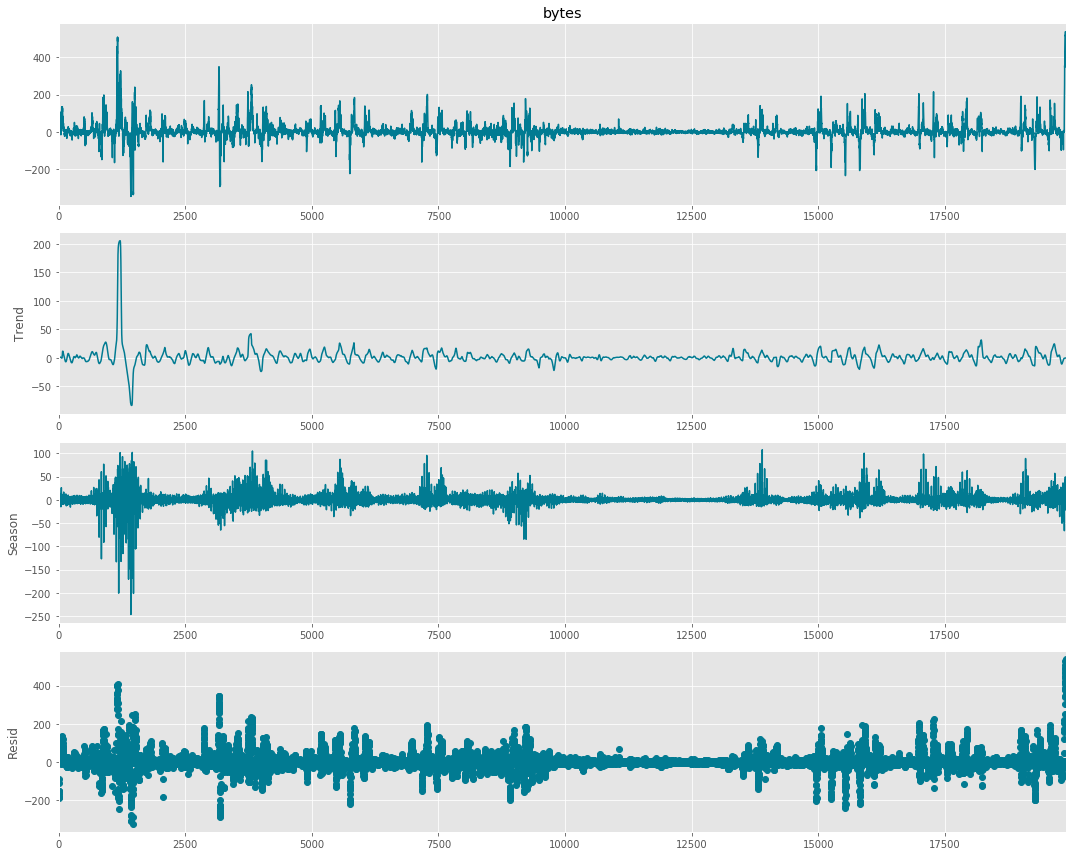

In [41]:
df = df[cols_selected]
print(df.info())

test_stl = True
if test_stl:
    cols=cols_selected
    df_result = pd.DataFrame()
    df_noise = pd.DataFrame()
    for col in cols:
        column = df[col]
        #result = STL(column, period=6, robust=True).fit()    
        #df_result[col] = result.trend

        result = STL(column, period=46, robust=True).fit()    
        df_result[col] = result.trend + result.seasonal
        df_noise[col] = result.resid

        plt.rcParams["figure.figsize"] = (15, 12)
        result.plot()
        plt.show()

In [42]:
df_result.to_csv('formatted/it_uk_fm_5m_noise_fm2.csv', index = False, header=True)
df_noise.to_csv('formatted/it_uk_fm_5m_noise_fm2_noise2.csv', index = False, header=True)